Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading the image...


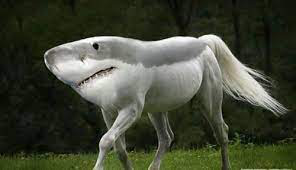

In [80]:
#!/usr/bin/env python3

# ============================

import torch
import torch.nn.functional as F
import torchvision
from PIL import Image
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
as_numpy = lambda x: x.detach().cpu().numpy()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]

def show_result(img, saliency, label = ""):
    img = np.array(img, dtype = float) / 255.0

    saliency = F.interpolate(saliency, size = img.shape[:2], mode = "bilinear")
    #print(img.shape)
    #print("before",saliency.shape)
    saliency = as_numpy(saliency)[0, 0]
    #print("after", saliency.shape)
    saliency = saliency - saliency.min()
    saliency = np.uint8(255 * saliency / saliency.max())
    heatmap = jet_colors[saliency]
    plt.imshow(0.5 * heatmap + 0.5 * img)
    plt.axis("off")
    plt.title(label)
    plt.show()

def show_fmap(img, saliency, scores):
    img = np.array(img, dtype = float) / 255.0

    saliency = F.interpolate(saliency, size = img.shape[:2], mode = "bilinear")

    ix = 1
    ids=5
    square=4
    for _ in range(square):
        for _ in range(square):
            feature = as_numpy(saliency)[0][ids]
            # print("after", saliency.shape)
            feature = feature - feature.min()
            feature = np.uint8(255 * feature / feature.max())
            heatmap = jet_colors[feature]
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("{}: {}".format(ids, scores[ids]))
            #plt.imshow(heatmap)
            plt.imshow(0.5 * heatmap + 0.5 * img)
            ix += 1
            ids += 100
    plt.show()


# define the preprocessing transform
image_shape = (224, 224)

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)
Horizontal_Flipping_Transformation = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=1) 
])
Vertical_Flipping_Transformation = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomVerticalFlip(p=1) 
])
Color_Transformation = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ColorJitter(brightness=(0.3,0.7), contrast=1,saturation=0, hue=0.4)
])
Crop_Transformation = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(size=(168,168)),
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
])
Rotate_Transformation = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(degrees=66)
])
from google.colab import drive
drive.mount('/content/drive')
json_path = '/content/drive/MyDrive/imagenet_class_index.json'

with open(json_path) as f:
    indx2label = json.load(f)


def decode_predictions(preds, k=5):
    # return the top k results in the predictions
    return [
        [(*indx2label[str(i)], i, pred[i]) for i in pred.argsort()[::-1][:k]]
        for pred in as_numpy(preds)
    ]

class Probe:
    def get_hook(self,):
        self.data = []
        def hook(module, input, output):
            self.data.append(output)
        return hook

def augmentation(transformer,img):
    x = transformer(img)[None]  # transform and reshape it to [1, C, *image_shape]
    trans = torchvision.transforms.ToPILImage()
    out = trans(x[0])
    return x,out
# load the image
print("loading the image...")
img_path = '/content/drive/MyDrive/shark.jpeg'
img = Image.open(img_path)
img

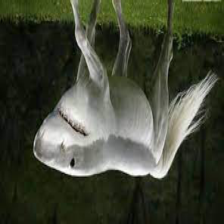

In [81]:
#transform,Horizontal_Flipping_Transformation,Vertical_Flipping_Transformation,Color_Transformation,Crop_Transformation,Rotate_Transformation
x,out = augmentation(Vertical_Flipping_Transformation, img)
x = x.to(device)
out

loading the model...


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


the prediction result:
n02892767 brassiere          459 16.11%
n03788365 mosquito_net       669  9.11%
n04033901 quill              749  4.98%
n03958227 plastic_bag        728  4.94%
n02815834 beaker             438  4.72%
Calculating the saliency of the top prediction...


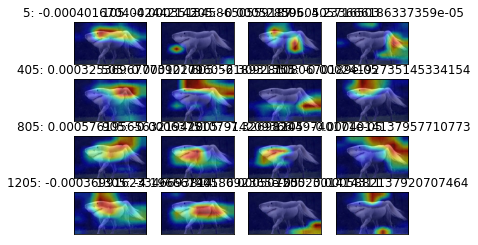

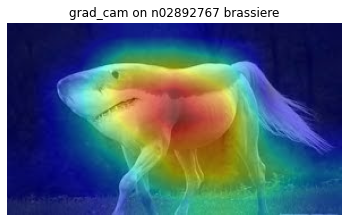

In [83]:
print("loading the model...")
### You can change the model here.
model = torchvision.models.resnet50(pretrained=True)
model.eval()
model.to(device)

#add a probe to model
probe = Probe()
#probe will save the output of the layer4 during forward
handle = model.layer4.register_forward_hook(probe.get_hook())

logits = model(x)
preds = logits.softmax(-1)

print("the prediction result:")
for tag, label, i, prob in decode_predictions(preds)[0]:
    print("{} {:16} {:5} {:6.2%}".format(tag, label, i, prob))

print("Calculating the saliency of the top prediction...")
target = preds.argmax().item()

### Grad_Cam
# get the last_conv_output
last_conv_output = probe.data[0]
handle.remove()

last_conv_output.retain_grad() #make sure the intermediate result save its grad

#backprop
logits[0, target].backward()
grad = last_conv_output.grad 
#taking average on the H-W panel
weight = grad.mean(dim = (-1, -2), keepdim = True)

scores = weight[0,:,0,0]
show_fmap(img, last_conv_output,scores)

saliency = (last_conv_output * weight).sum(dim = 1, keepdim = True)

#relu

saliency = saliency.clamp(min = 0)

show_result(img, saliency, "grad_cam on {} {}".format(*indx2label[str(target)]))